In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pathlib

from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression

from speedtest.utils.visualization import plot_comparison_histogram
from speedtest.utils.transform import HourExtractor, WeekdayExtractor, OutlierClipper, RatioCalculator

In [3]:
# Reduce default figure size
plt.rcParams['figure.figsize'] = (4, 3)

In [4]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [5]:
cfg = OmegaConf.load('../../speedtest/conf/config.yaml')

## Load dataset

In [6]:
INPUTS = ['download_mbit', 'upload_mbit', 'time_utc']
TARGET = 'cat_technology'

In [7]:
df = pd.read_csv('../../data/processed/netztest-opendata-processed.csv')
df = df[INPUTS + [TARGET]]

In [8]:
df.sample(5)

,download_mbit,upload_mbit,time_utc,cat_technology
32530,32.046,23.194,2023-09-15 11:49:49,4G
5241,52.342,20.875,2023-08-24 09:24:30,5G
8168,84.021,12.429,2023-08-26 13:21:29,4G
20343,39.268,1.168,2023-09-05 13:49:09,4G
11603,205.640,33.119,2023-08-29 12:38:39,5G


## Preprocessing

<img src="image.png" alt="" width="800"/>

## Hour of day / day of week

In [9]:
df.time_utc

0        2023-08-20 00:00:12
1        2023-08-20 00:00:34
2        2023-08-20 00:01:34
3        2023-08-20 00:06:20
4        2023-08-20 00:12:17
                ...         
38436    2023-09-20 10:38:48
38437    2023-09-20 10:38:56
38438    2023-09-20 10:40:09
38439    2023-09-20 10:40:25
38440    2023-09-20 10:42:34
Name: time_utc, Length: 38441, dtype: object

In [10]:
HourExtractor().transform(df.time_utc.values)

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [10],
       [10],
       [10]])

In [11]:
WeekdayExtractor().transform(df.time_utc)

array([[6],
       [6],
       [6],
       ...,
       [2],
       [2],
       [2]])

## download_mbits_clean

### Clip outliers

In [12]:
OutlierClipper(upper_limit=.95, lower_limit=0).fit_transform(df.download_mbit)

array([[ 93.94 ],
       [127.112],
       [ 98.521],
       ...,
       [  5.395],
       [239.933],
       [ 14.67 ]])

In [13]:
df['download_mbit_wo_outliers'] = OutlierClipper(
    upper_limit=.95, lower_limit=0
).fit_transform(df.download_mbit)

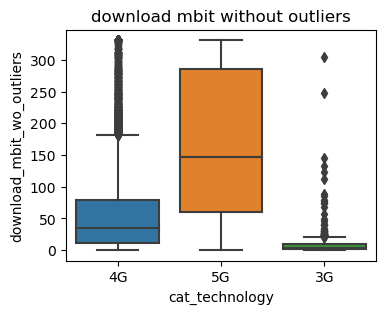

In [14]:
sns.boxplot(x='cat_technology', y='download_mbit_wo_outliers', data=df)
plt.title('download mbit without outliers')
plt.show()

## ratio up down

In [15]:
RatioCalculator().transform(df[['upload_mbit', 'download_mbit']])

array([[0.28553332],
       [0.02681887],
       [0.19107601],
       ...,
       [0.4626506 ],
       [0.20764964],
       [1.19318337]])

## Full pipeline:

In [16]:
X = df.copy()
y = X.pop(cfg.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42, stratify=y)

In [26]:
# Full transformer pipeline
hour_of_day_transform = make_pipeline(
    SimpleImputer(strategy='most_frequent'), HourExtractor(), MinMaxScaler()
)

weekday_transform = make_pipeline(
    SimpleImputer(strategy='most_frequent'), WeekdayExtractor(), OneHotEncoder()
)

numeric_transform = make_pipeline(
    SimpleImputer(strategy='median'),
    OutlierClipper(), 
    MinMaxScaler()
)

down_up_ratio_transform = make_pipeline(
    SimpleImputer(strategy='median'),
    RatioCalculator(),
    OutlierClipper() 
)

preprocessor = ColumnTransformer(
    transformers=[
        ('hour', hour_of_day_transform, ['time_utc']),
        ('weekday', weekday_transform, ['time_utc']),
        ('download', numeric_transform, ['download_mbit']),
        ('ratio', down_up_ratio_transform, ['upload_mbit', 'download_mbit']),
    ]
)

In [27]:
preprocessor.fit_transform(X_train)

array([[0.56521739, 0.        , 0.        , ..., 0.        , 0.00427459,
        0.94680458],
       [0.34782609, 0.        , 0.        , ..., 0.        , 0.03228159,
        0.00780731],
       [0.43478261, 0.        , 1.        , ..., 0.        , 0.15089478,
        0.11109149],
       ...,
       [0.69565217, 0.        , 0.        , ..., 0.        , 0.36494461,
        0.11881392],
       [0.39130435, 0.        , 0.        , ..., 0.        , 0.0770551 ,
        0.19498932],
       [0.52173913, 1.        , 0.        , ..., 0.        , 0.05027073,
        0.03123865]])

In [19]:
#check = pd.DataFrame(preprocessor.fit_transform(X_train), columns=['hour_of_day', 'day_of_week', 'download_mbit_clean', 'ratio_up_down'])

In [30]:
pipe = Pipeline([
    ('prep', preprocessor),
    ('logreg', LogisticRegression())
])

# Hyperparameters for training
param_grid = {
    'prep__download__outlierclipper__upper_limit': [.95, .99, .999],
    'prep__download__outlierclipper__lower_limit': [0],
    'logreg__C': [10**(i) for i in np.arange(-2, 3, 1, dtype=float)],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__class_weight': ['balanced', None],
    'logreg__solver': ['liblinear'],
    'logreg__max_iter': [200]
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=True
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('hour',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('hourextractor',
                                                                                          HourExtractor()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['time_utc']),
                                                                        ('weekday',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('weekdayextractor',
                                                                                          We...
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'logreg__class_weight': ['balanced', None],
                         'logreg__max_iter': [200],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear'],
                         'prep__download__outlierclipper__lower_limit': [0],
                         'prep__download__outlierclipper__upper_limit': [0.95,
                                                                         0.99,
                                                                         0.999]},
             scoring='f1_macro', verbose=True)

In [31]:
grid.best_params_

{'logreg__C': 10.0,
 'logreg__class_weight': 'balanced',
 'logreg__max_iter': 200,
 'logreg__penalty': 'l1',
 'logreg__solver': 'liblinear',
 'prep__download__outlierclipper__lower_limit': 0,
 'prep__download__outlierclipper__upper_limit': 0.99}

In [32]:
y_test_pred = grid.predict(X_test)

In [35]:
print(sklearn.metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          3G       0.30      0.08      0.13       556
          4G       0.79      0.90      0.84      8847
          5G       0.69      0.53      0.60      3411

    accuracy                           0.77     12814
   macro avg       0.60      0.50      0.52     12814
weighted avg       0.74      0.77      0.75     12814



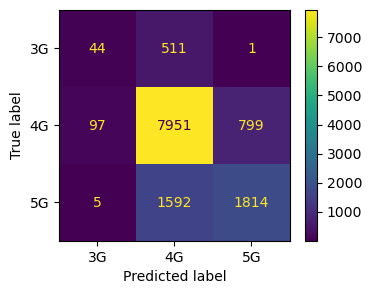

In [36]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.show()